# Chess FEN Generator
Original: \
https://www.kaggle.com/koryakinp/chess-fen-generator



### Download Data

In [ ]:
!pip install --upgrade fastai git+https://gitlab.aicrowd.com/yoogottamk/aicrowd-cli.git >/dev/null
%load_ext aicrowd.magic

  Running command git clone -q https://gitlab.aicrowd.com/yoogottamk/aicrowd-cli.git /tmp/pip-req-build-td7t0uil


In [ ]:
API_KEY = 'b46152c118edae059e08ebd1f8ada78f' #Please enter your API Key [https://www.aicrowd.com/participants/me]
%aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [ ]:
%aicrowd dataset download --challenge chess-configuration -j 3

In [ ]:
!rm -rf data
!mkdir data

!unzip -q train.zip  -d data/ 
!unzip -q val.zip -d data/ 
!unzip -q test.zip  -d data/ 

!mv train.csv data/train.csv
!mv val.csv data/val.csv
!mv sample_submission.csv data/sample_submission.csv

### Import packages

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
import warnings
warnings.filterwarnings('ignore')

### Data Import

In [ ]:
#DATADIR = 'D:/Datasets/CHESS/CONFIGURATION/'
DATADIR = './data/'

In [ ]:
train_df = pd.read_csv(DATADIR+"train.csv")
val_df = pd.read_csv(DATADIR+"val.csv")

test_df = pd.read_csv(DATADIR+"sample_submission.csv")

In [ ]:
train_size = 10000
val_size = 4000
test_size = 10000

train = [f'{DATADIR}train/{i}.jpg' for i in train_df.ImageID]
val = [f'{DATADIR}val/{i}.jpg' for i in val_df.ImageID]
test = [f'{DATADIR}test/{i}.jpg' for i in test_df.ImageID]

train = train[:train_size]
val =  val[:val_size]


In [ ]:
mpimg.imread(test[0]).shape

(254, 254, 3)

### Function to extract FEN 

In [ ]:
def fen_from_filename(filename):
    base = os.path.basename(filename)
    image_id = int(os.path.splitext(base)[0])
    #print(image_id)
    fen = train_df.iloc[image_id].label
    return fen

#### Examples:

In [ ]:
print(fen_from_filename(train[0]))
print(fen_from_filename(train[1]))
print(fen_from_filename(train[2]))

1rbqkb1r/p1p1n1pp/1pn1p3/1P1p1p2/3P4/N3B2P/P1PNPPP1/R2QKB1R
2bk4/2q1p3/3p3P/5r2/r5nP/P2K2N1/8/2q1NB1R
3rnq2/3k1p2/5rP1/pppp1P2/P1BP2P1/RPP1K2N/3B3P/1N5R


### Plotting samples

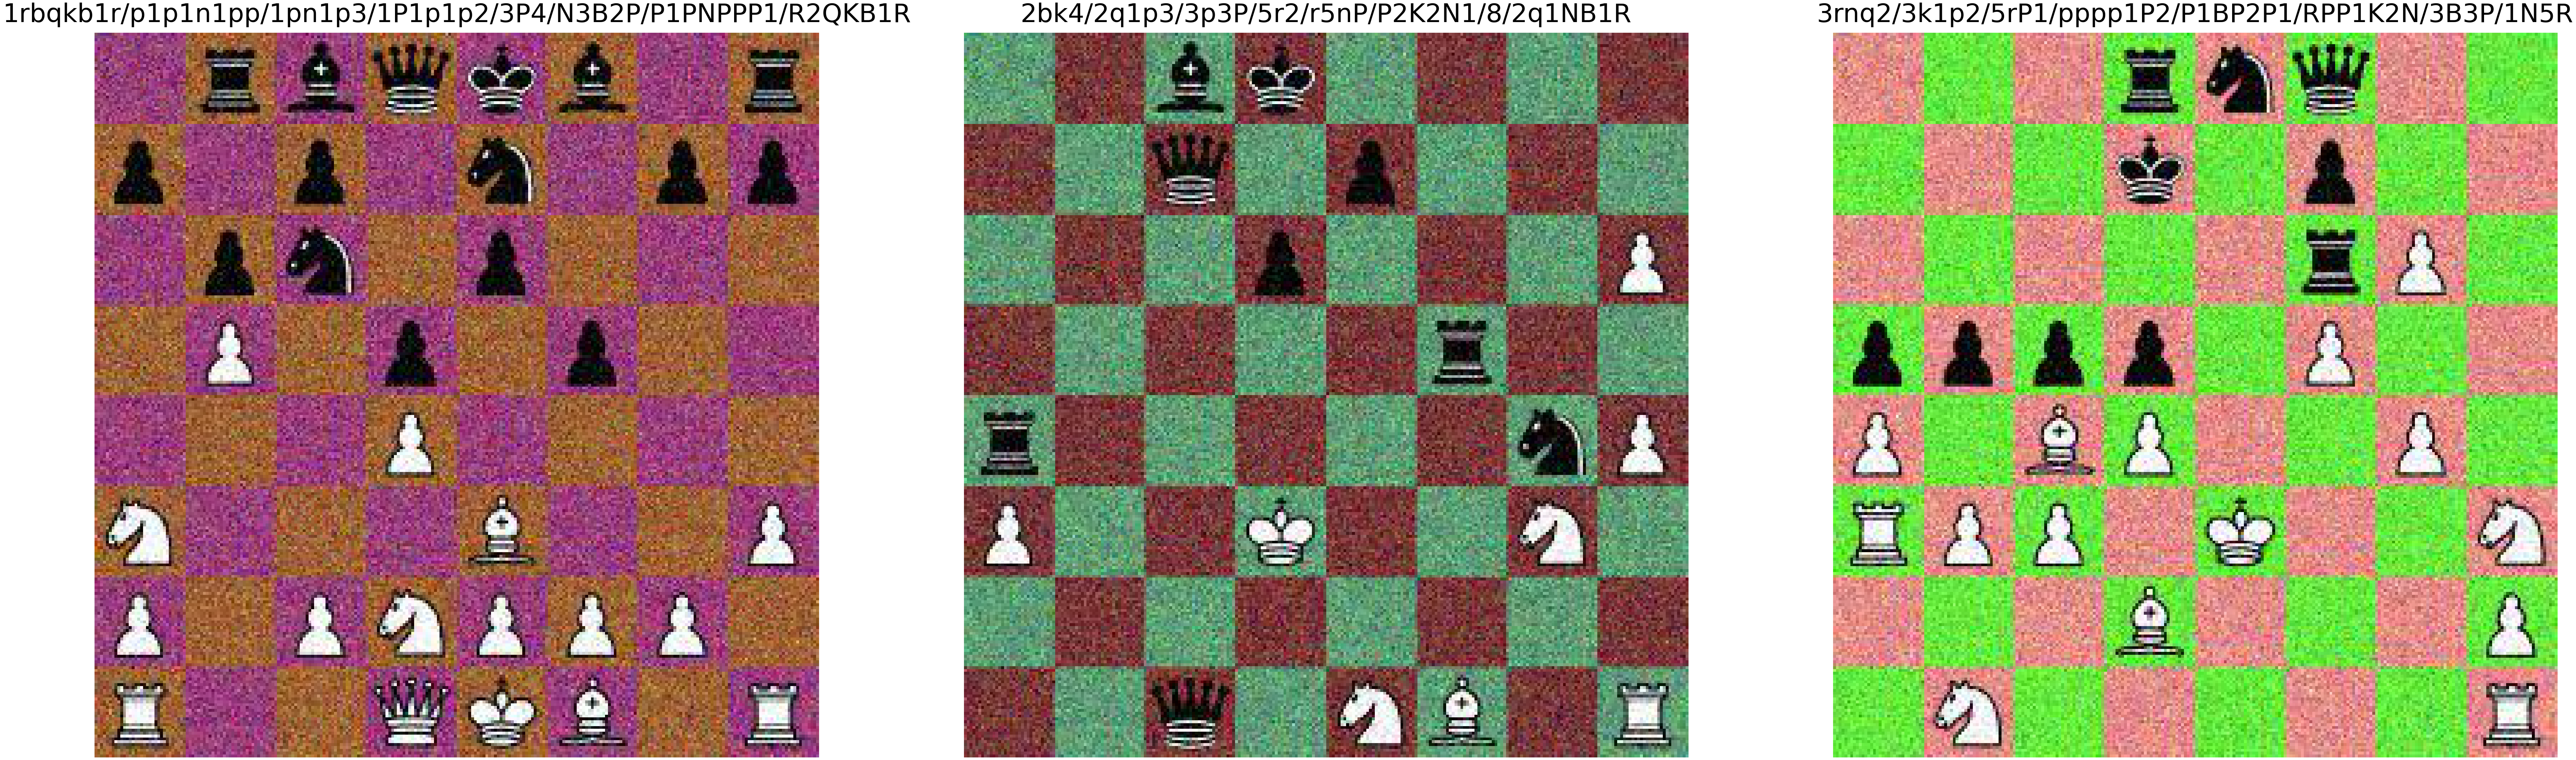

In [ ]:
f, axarr = plt.subplots(1,3, figsize=(120, 120))

for i in range(0,3):
    axarr[i].set_title(fen_from_filename(train[i]), fontsize=70, pad=30)
    axarr[i].imshow(mpimg.imread(train[i]))
    axarr[i].axis('off')

### Functions to convert FEN to one-hot encoded vectors and vice-versa

In [ ]:
piece_symbols = 'prbnkqPRBNKQ'

def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[/]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '/'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

#### Function to proccess an image:
-  downsample an image to 200 by 200 pixel
-  split an image of the chess board to 64 images of individual squares
-  drop redundant dimensions, reshape

In [ ]:
DOWNSAMPLE_SIZE = 200  # must be % 8 = 0 and < img.shape
SQUARE_SiZE = int(DOWNSAMPLE_SIZE/8)

def process_image(img, size = DOWNSAMPLE_SIZE):
    downsample_size = size
    square_size = int(downsample_size/8)
    img_read = io.imread(img)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)

### Functions for sampling batches for training and evaluation:

In [ ]:
def train_gen(features, labels, batch_size):
    for i, img in enumerate(features):
        y = onehot_from_fen(fen_from_filename(img))
        x = process_image(img)
        yield x, y

def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_image(img)

### Define a model:

In [ ]:
# CNN model
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(SQUARE_SiZE, SQUARE_SiZE, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(13))
model.add(Activation('softmax'))
model.compile(
  loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the model:

In [ ]:
model.fit_generator(train_gen(train, None, 64), epochs=50, steps_per_epoch=1000)

Epoch 1/50
10000/10000 [==============================] - 151s 15ms/step - loss: 0.0236 - accuracy: 0.9943
Epoch 2/50
10000/10000 [==============================] - 0s 1us/step - loss: 0.0050 - accuracy: 0.9989


### Testing the model:

In [ ]:
res = (
  model.predict_generator(pred_gen(val, 64), steps=val_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

### Calculating an accuracy of the model:

In [ ]:
def fen_from_filename_val(filename):
    base = os.path.basename(filename)
    image_id = int(os.path.splitext(base)[0])
    #print(image_id)
    fen = val_df.iloc[image_id].label
    return fen

In [ ]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
val_fens = np.array([fen_from_filename_val(fn) for fn in val])

final_accuracy = (pred_fens == val_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.99950%


### Sample images and display predicted FEN 

In [ ]:
def display_with_predicted_fen(image):
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()

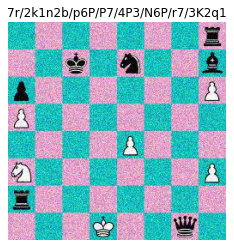

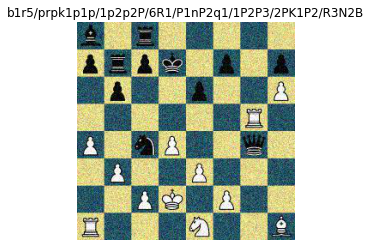

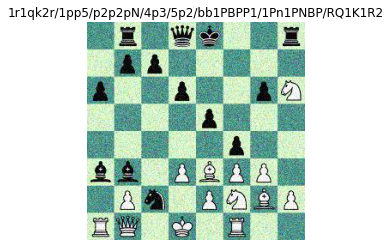

In [ ]:
display_with_predicted_fen(test[0])
display_with_predicted_fen(test[1])
display_with_predicted_fen(test[2])

### Prediction and submite

In [ ]:
preds = (
  model.predict_generator(pred_gen(test, 64), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

In [ ]:
 test_df['label'] = [fen_from_onehot(i) for i in preds ]

In [ ]:
test_df

,ImageID,label
0,0,7r/2k1n2b/p6P/P7/4P3/N6P/r7/3K2q1
1,1,b1r5/prpk1p1p/1p2p2P/6R1/P1nP2q1/1P2P3/2PK1P2/...
2,2,1r1qk2r/1pp5/p2p2pN/4p3/5p2/bb1PBPP1/1Pn1PNBP/...
3,3,3k2n1/7p/qr3N2/p1p1P1p1/2P1N1P1/P1K3BB/4r2P/R7
4,4,3r1k1r/7n/1pBPpn1b/1P5P/p2R1P2/P3P2p/7K/1b2B1R1
...,...,...
9995,9995,3qrbn1/2pN2k1/P3pnp1/1p1P2Pr/3P1p1P/2P2P1K/P4B...
9996,9996,8/2bk3p/4r1pP/6P1/2P4R/1B1PBN2/8/R3KQ2
9997,9997,rn2r3/p2p1p1k/b2b4/2p1pp2/1qN1P2n/P2PKP1P/8/R1B4R
9998,9998,8/pq1n1p1r/1k1p3n/5P2/1Pr4P/1R2P2P/R2P1Q2/2BK4


In [ ]:
test_df.to_csv("FENGenerator_submission.csv", index=False)

In [ ]:
try:
    from google.colab import files
    files.download('FENGenerator_submission.csv') 
except:
    print("Option Only avilable in Google Colab")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Save Model

https://www.tensorflow.org/guide/keras/save_and_serialize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/FENGenerator_model')

### Load Model

In [ ]:
new_model = load_model('/content/drive/MyDrive/FENGenerator_model')

In [ ]:
def display_with_predicted_fen(image):
    pred = new_model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()

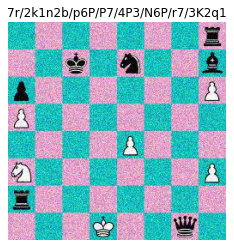

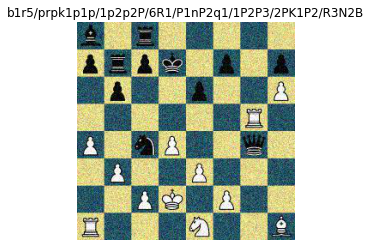

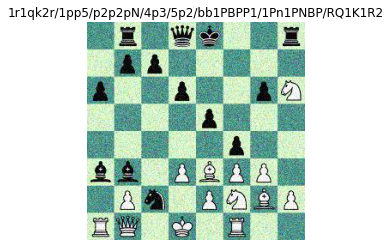

In [ ]:
display_with_predicted_fen(test[0])
display_with_predicted_fen(test[1])
display_with_predicted_fen(test[2])